In [1]:
#SIZE_TEST = 50000
N_SENTENCES_TRAIN = 20000
N_SENTENCES_TEST = 5000
N_EPOCHS = 1
CACHED = True

In [20]:
%load_ext rpy2.ipython

In [2]:
import sys
sys.path.append('../src')

In [3]:
import numpy as np

# Creates Dataset

In [4]:
# Creates Nietzsche dataset
import dataset
reload(dataset)

data_obj = dataset.ToyLang()
data_obj.create(n_sentences_train=N_SENTENCES_TRAIN, n_sentences_test=N_SENTENCES_TEST)

Using TensorFlow backend.


Generating raw text, with training size: 20000 and testing size 5000
Generated train sequence - 240761 characters
Generated test sequence - 60139 characters
Total vocabulary size:  7
Total Patterns:  240726
Total Patterns:  60104


In [5]:
print data_obj.train['X'].shape
print data_obj.train['y'].shape
print len(data_obj.train_raw)
print ''
print data_obj.test['X'].shape
print data_obj.test['y'].shape
print len(data_obj.test_raw)

(240726, 35, 7)
(240726, 7)
240761

(60104, 35, 7)
(60104, 7)
60139


# Creates and trains character model

In [6]:
import model
reload(model)

nn_model = model.VanillaLSTM(data_obj, 128, n_epochs=1)
nn_model.build()

if CACHED:
    nn_model.load_from_file('../models/parenthesis_0')
else:
    for i in range(N_EPOCHS):
        nn_model.train()
        nn_model.save('../models/parenthesis_' + str(i))

Epoch 1/1
240726/240726 [==============================] - 240s - loss: 0.5804 - acc: 0.7301   
('Saved model to file:', '../models/parenthesis_0')


In [7]:
# Creates a sentence
nn_model.complete_sentence(50)

Dimensions: (1, 35, 7)
[0 0 0 0 6 1 1 1 1 0 3 0 0 0 6 6 1 1 1 1 0 0 0 0 6 6 1 1 1 1 2 0 0 4 0 0 6
 6 1 1 1 1 0 0 0 0 6 6 6 1 1 1 1 0 3 3 0 0 5 0 6 6 1 1 1 1 0 3 2 0 0 0 6 6
 1 1 1 1 2 0 3 0 0 0 6]


'((((4))))(1(((44))))((((44))))0((2((44))))((((444))))(11((3(44))))(10(((44))))0(1(((4'

# Extracts States

In [8]:
# Gets hidden states
states = nn_model.extract_states()
print states.shape

(60139, 32)


# Computes Features

In [9]:
import features
reload(features)
features_obj = features.ToyFeatures(data_obj)
features_obj.build_feature_functions()
computed_features = features_obj.compute_feat_matrix()

computed_features

Computing feature values
0 out of 13 features processed
10 out of 13 features processed


{'feat_matrix': array([[1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 2],
        ..., 
        [0, 0, 0, ..., 0, 0, 2],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0]]),
 'labels': ['0',
  '1',
  '2',
  '3',
  '4',
  '(',
  ')',
  'indent-0',
  'indent-1',
  'indent-2',
  'indent-3',
  'indent-4',
  'indent-seq']}

# Computes and Plots Scores

In [77]:
import score
reload(score)
score_obj = score.CorrelationScore(states, computed_features['feat_matrix'])
score_obj.compute_scores()

Scoring feature 0 out of 13
Scoring feature 10 out of 13
Scoring feature 12 out of 13


Filtering feature matrix


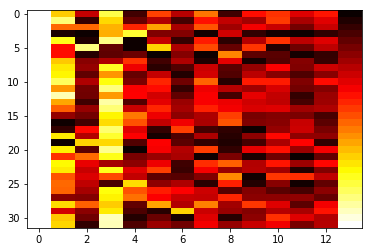

['0', '1', '2', '3', '4', '(', ')', 'indent-0', 'indent-1', 'indent-2', 'indent-3', 'indent-4', 'indent-seq']


In [78]:
%matplotlib inline

N_FEATURES_TO_PLOT = 50

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import os
import numpy as np

to_plot = score_obj.filter_scores(N_FEATURES_TO_PLOT)

n_values   = to_plot.shape[0]
dummy_vals = np.linspace(0,1,num=n_values)
dummy_vals = np.expand_dims(dummy_vals, axis=1)
to_plot  = np.append(to_plot, dummy_vals, axis = 1)

plt.imshow(to_plot, cmap='hot',
                      norm=Normalize(vmin=0),
                      interpolation='nearest',
                      aspect='auto')
plt.show()
#plt.savefig('correlation_matrix.pdf',  bbox_inches='tight')

colnames = computed_features['labels']
print computed_features['labels'][:N_FEATURES_TO_PLOT]

    Neuron  Feature  Correlation
1        1 indent-1 0.0814741599
2        2 indent-1 0.2752243723
3        3 indent-1 0.2248844281
4        4 indent-1 0.2979821291
5        5 indent-1 0.0514814973
6        6 indent-1 0.1398487883
7        7 indent-1 0.5612666836
8        8 indent-1 0.3257117692
9        9 indent-1 0.1196788529
10      10 indent-1 0.1069675377
11      11 indent-1 0.0444207469
12      12 indent-1 0.2601505170
13      13 indent-1 0.0895923290
14      14 indent-1 0.3360621545
15      15 indent-1 0.3486475046
16      16 indent-1 0.4593410166
17      17 indent-1 0.4919705402
18      18 indent-1 0.0566875373
19      19 indent-1 0.0443387786
20      20 indent-1 0.0312920834
21      21 indent-1 0.0593732582
22      22 indent-1 0.1706777511
23      23 indent-1 0.5114807097
24      24 indent-1 0.2125851583
25      25 indent-1 0.5713275402
26      26 indent-1 0.4108167094
27      27 indent-1 0.1169874295
28      28 indent-1 0.4200970460
29      29 indent-1 0.2304215865
30      30

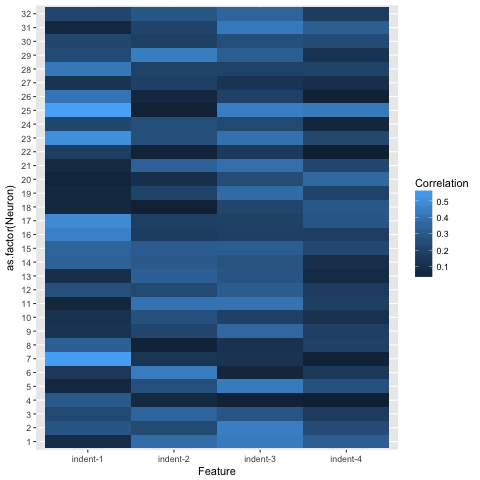

In [79]:
%%R -i to_plot,colnames
library(ggplot2)
library(dplyr)
library(tidyr)

data <- as.data.frame(to_plot)
names(data) <- colnames

data[['Neuron']] <- 1:nrow(data)
data <- gather(data, key='Feature', value='Correlation', -Neuron) %>%
            filter(Feature %in% c('indent-1', 'indent-2','indent-3', 'indent-4'))
print(data)
ggplot(data, aes(x=Feature, y=as.factor(Neuron), fill=Correlation)) + geom_bin2d(aes='identity')

    Neuron Feature  Correlation
1        1       1 0.6717188408
2        2       1 0.8596257321
3        3       1 0.5208845967
4        4       1 0.0307781413
5        5       1 0.7711781611
6        6       1 0.3855976039
7        7       1 0.3852891007
8        8       1 0.6644860490
9        9       1 0.7113804417
10      10       1 0.7319080957
11      11       1 0.8360050559
12      12       1 0.5922404869
13      13       1 0.9243803492
14      14       1 0.6169223947
15      15       1 0.5047044961
16      16       1 0.2051416095
17      17       1 0.0107852897
18      18       1 0.0587661273
19      19       1 0.7122527977
20      20       1 0.0047162227
21      21       1 0.7248855567
22      22       1 0.4369940921
23      23       1 0.7385162143
24      24       1 0.7165696157
25      25       1 0.4909409697
26      26       1 0.5221097564
27      27       1 0.5139597107
28      28       1 0.1911285821
29      29       1 0.6926638556
30      30       1 0.2974375341
31      

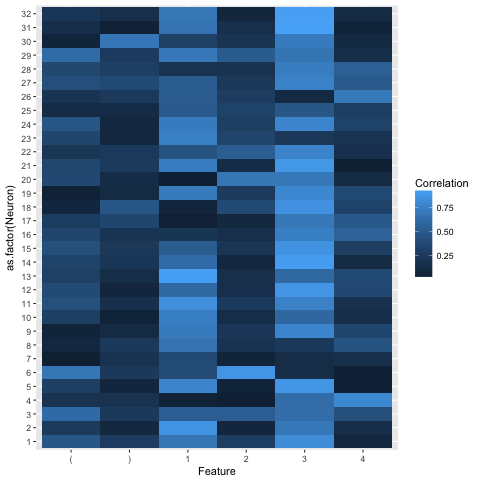

In [80]:
%%R -i to_plot,colnames
library(ggplot2)
library(dplyr)
library(tidyr)

data <- as.data.frame(to_plot)
names(data) <- colnames

data[['Neuron']] <- 1:nrow(data)
data <- gather(data, key='Feature', value='Correlation', -Neuron) %>%
            filter(Feature %in% c('1', '2', '3', '4', '(', ')'))
print(data)
ggplot(data, aes(x=Feature, y=as.factor(Neuron), fill=Correlation)) + geom_bin2d(aes='identity')

Filtering feature matrix


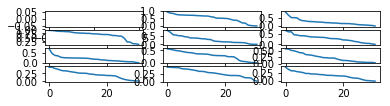

In [12]:
# Second viz
to_plot = score_obj.filter_scores(N_FEATURES_TO_PLOT)

if to_plot.shape[1] <= 4:
    ncol = 1
elif 4 < to_plot.shape[1] <= 8:
    ncol = 2
else:
    nplots = min(12, to_plot.shape[1])
    to_plot = to_plot[:,:nplots]
    ncol = 3

for i in range(to_plot.shape[1]):
    neuron_series = np.sort(to_plot[:,i])[::-1]
    plt.subplot(to_plot.shape[1],ncol,i+1)
    plt.plot(neuron_series)

plt.show()
#plt.savefig('individual_correlation_scores.pdf',  bbox_inches='tight')

# More complex feature score - multineuron

In [69]:
reload(score)

score_obj = score.MultiNeuronPred(states, 
                computed_features['feat_matrix'],
                computed_features['labels'])
score_obj.compute_scores()


Scoring feature 0 out of 13
Feature: 0
Fitting model
Computing score
Accuracy: 0.99806763285
Feature: 1
Fitting model
Computing score
Accuracy: 0.99801980198
Feature: 2
Fitting model
Computing score
Accuracy: 0.999196787149
Feature: 3
Fitting model
Computing score
Accuracy: 0.997506234414
Feature: 4
Fitting model
Computing score
Accuracy: 0.999120823914
Feature: (
Fitting model
Computing score
Accuracy: 0.999650069986
Feature: )
Fitting model
Computing score
Accuracy: 0.999925009374
Feature: indent-0
Fitting model
Cant compute score
Feature: indent-1
Fitting model
Computing score
Accuracy: 0.831666146218
Feature: indent-2
Fitting model
Computing score
Accuracy: 0.794810620843
Scoring feature 10 out of 13
Feature: indent-3
Fitting model
Computing score
Accuracy: 0.736283642858
Feature: indent-4
Fitting model
Computing score
Accuracy: 0.63307966749
Feature: indent-seq
Fitting model
Computing score
Cant compute score


In [70]:
score_obj.filter_scores(50).shape

Filtering feature matrix


(32, 13)

Filtering feature matrix


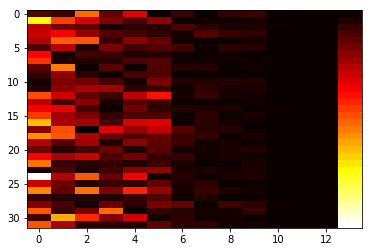

0 0
1 1
2 2
3 3
4 4
5 (
6 )
7 indent-0
8 indent-1
9 indent-2
10 indent-3
11 indent-4
12 indent-seq


In [71]:
%matplotlib inline

N_FEATURES_TO_PLOT = 35

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import os
import numpy as np

to_plot = score_obj.filter_scores(N_FEATURES_TO_PLOT)

n_values   = to_plot.shape[0]
dummy_vals = np.linspace(0,np.max(to_plot),num=n_values)
dummy_vals = np.expand_dims(dummy_vals, axis=1)
to_plot  = np.append(to_plot, dummy_vals, axis = 1)

plt.imshow(to_plot, cmap='hot',
                      norm=Normalize(vmin=0),
                      interpolation='nearest',
                      aspect='auto')
plt.show()
#plt.savefig('correlation_matrix.pdf',  bbox_inches='tight')

for i,l in enumerate(computed_features['labels'][:N_FEATURES_TO_PLOT]):
    print i,l

Filtering feature matrix


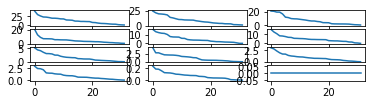

In [72]:
# Second viz
to_plot = score_obj.filter_scores(N_FEATURES_TO_PLOT)

if to_plot.shape[1] <= 4:
    ncol = 1
elif 4 < to_plot.shape[1] <= 8:
    ncol = 2
else:
    nplots = min(12, to_plot.shape[1])
    to_plot = to_plot[:,:nplots]
    ncol = 3

for i in range(to_plot.shape[1]):
    neuron_series = np.sort(to_plot[:,i])[::-1]
    plt.subplot(to_plot.shape[1],ncol,i+1)
    plt.plot(neuron_series)

plt.show()
#plt.savefig('individual_correlation_scores.pdf',  bbox_inches='tight')

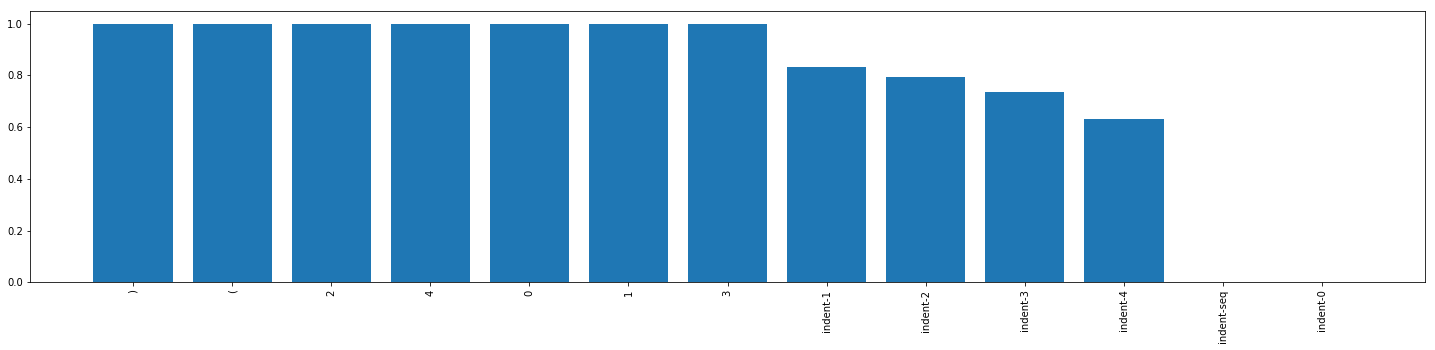

In [73]:
# Third viz: shows score per rule
fig_size = [25,5]
plt.rcParams["figure.figsize"] = fig_size

feat_scores = score_obj.model_scores
feat_names =  computed_features['labels']

dorder = np.argsort(feat_scores)[::-1][:50]

scores = np.array(feat_scores)[dorder]
names = np.array(feat_names)[dorder]

fig, ax = plt.subplots()
plt.bar(np.arange(dorder.shape[0]), scores)
plt.xticks(np.arange(dorder.shape[0]), names, rotation='vertical')

plt.show()
# print feat_names[order]

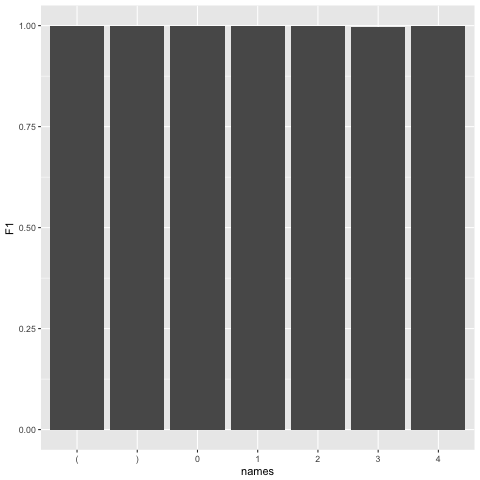

In [74]:
%%R -i feat_scores,feat_names
library(ggplot2)
library(dplyr)

to_plot <- data.frame(F1=feat_scores, names=feat_names) %>% 
            filter(feat_names %in% c(as.character(0:5), ')', '('))
ggplot(to_plot, aes(x=names, y=F1)) + geom_bar(stat='identity')

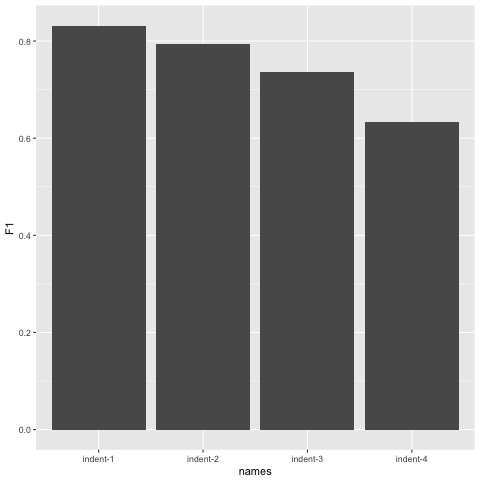

In [76]:
%%R -i feat_scores,feat_names
library(ggplot2)
library(dplyr)

to_plot <- data.frame(F1=feat_scores, names=feat_names) %>% 
            filter(feat_names %in% c('indent-1', 'indent-2','indent-3', 'indent-4'))
ggplot(to_plot, aes(x=names, y=F1)) + geom_bar(stat='identity')

In [18]:
gt_50 = np.array(feat_scores) > .5
np.array(feat_names)[gt_50]

array(['0', '1', '2', '3', '4', '(', ')', 'indent-1', 'indent-2',
       'indent-3', 'indent-4'],
      dtype='|S10')

# Plots feature groups

In [19]:
from numpy.core.defchararray import startswith

feat_scores = np.array(score_obj.model_scores)
feat_names =  np.array(computed_features['labels'])

def print_scores(name, MAX_PRINT=25):
    indices = np.where(startswith(feat_names, name))[0]
    for f_i in indices[:MAX_PRINT]:
        print feat_names[f_i], feat_scores[f_i] 
    print 'AVERAGE:', feat_scores[indices].mean()

# Stop words feature
print '** Stop words feature:'
print_scores('')

** Stop words feature:
0 0.99806763285
1 0.99801980198
2 0.999196787149
3 0.997506234414
4 0.999120823914
( 0.999650069986
) 0.999925009374
indent-0 0.0
indent-1 0.831666146218
indent-2 0.794810620843
indent-3 0.736283642858
indent-4 0.63307966749
indent-seq 0.0
AVERAGE: 0.768255879775
